Intelligent Well Anomaly Detection System (Unsupervised ML)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix


In [2]:
df = pd.read_csv("well_data.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime").reset_index(drop=True)

df.describe()


,datetime,standpipe_pressure,flow_rate,hook_load,rpm,torque,mud_weight,rop,pump_pressure
count,1000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2024-01-21 19:29:59.999999744,3039.556611,502.833449,200.087513,119.812808,25.315612,9.985979,29.315458,2802.690386
min,2024-01-01 00:00:00,2513.809899,382.384455,154.707318,90.705513,15.469889,9.130146,8.413847,2283.628859
25%,2024-01-11 09:45:00,2905.805893,475.750332,190.280006,112.625795,22.997566,9.791892,25.924051,2703.098126
50%,2024-01-21 19:30:00,3007.161271,502.523085,199.996239,120.001846,25.040467,9.987152,29.548718,2800.697166
75%,2024-02-01 05:15:00,3106.277741,529.155287,209.913730,126.669454,27.073140,10.183734,33.410553,2901.276171
max,2024-02-11 15:00:00,4550.494520,627.724303,258.893566,152.430930,54.941969,10.929490,47.645276,3236.475358
std,NaN,263.437492,39.898175,14.751814,10.271325,4.138583,0.302217,5.883739,145.843603


In [3]:
df = df.set_index("datetime")
df = df.interpolate(method="time")
df = df.reset_index()


In [4]:
features = df.drop(columns=["datetime"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)


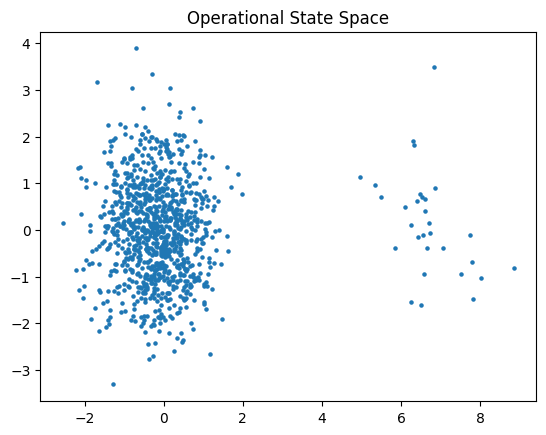

In [5]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:,0], X_pca[:,1], s=5)
plt.title("Operational State Space")
plt.show()


In [7]:
model = IsolationForest(
    n_estimators=300,
    contamination=0.02,
    random_state=42
)

model.fit(X_scaled)

df["anomaly"] = model.predict(X_scaled)


In [8]:
import joblib

joblib.dump(model, "anomaly_model.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

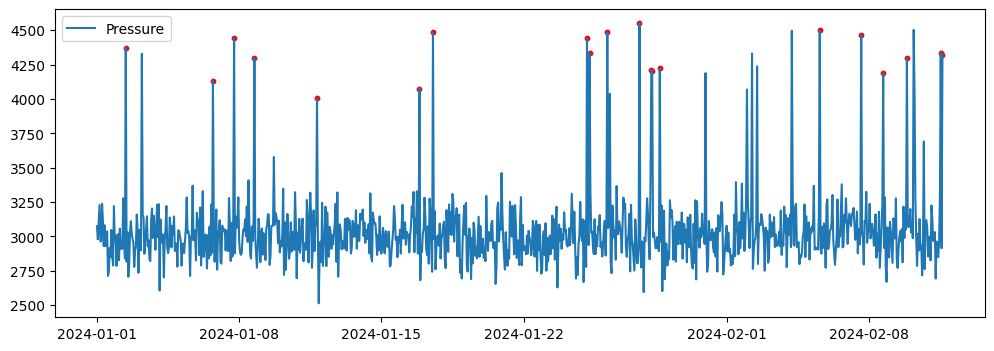

In [9]:
anomalies = df[df["anomaly"] == -1]

plt.figure(figsize=(12,4))
plt.plot(df["datetime"], df["standpipe_pressure"], label="Pressure")
plt.scatter(anomalies["datetime"],
            anomalies["standpipe_pressure"],
            color="red", s=10)
plt.legend()
plt.show()


In [10]:
df["anomaly_score"] = model.decision_function(X_scaled)


In [ ]:
def detect_anomaly(new_data):
    scaled = scaler.transform(new_data)
    return model.predict(scaled), model.decision_function(scaled)
